In [6]:
from pyspark.sql.functions import array_contains, col,shuffle, lit, row_number, rand, udf, col
from pyspark.sql.window import Window
import pyspark
import matplotlib.pyplot as plt
from functools import reduce

In [1]:
df_normalized_pairs = catalog.load('df_normalized_pairs')

                    INFO     Loading data from 'df_normalized_pairs' (SparkDataSet)...          ]8;id=238840;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=493563;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

In [2]:
df_normalized_pairs.show()

+------------+--------------------+--------------------+--------------------+--------------------+----------+----------+--------------------+--------------------+--------------------+------------------+-------+
|reference_id|               brand|                name|            alt_name|                tags|  latitude| longitude|     category_fields|     name_normalized| alt_name_normalized|            run_id|country|
+------------+--------------------+--------------------+--------------------+--------------------+----------+----------+--------------------+--------------------+--------------------+------------------+-------+
| 45925951921|                null|         Rödelsmühle|           Walkmühle|"license"=>"ODbL"...|50.7180844|11.7042457|[man_made=watermi...|         rödelsmühle|           walkmühle|20230901-test-0001|    deu|
| 46449354821|                null|            Geithain|      Mark Ottenhain|"license"=>"ODbL"...|51.0639507|12.7077891|                  []|            gei

In [6]:
df_normalized_pairs.where(col("name").contains("廳")).show(100)

+--------------------+-----------+--------------------+-------------------+
|                name|   alt_name|     name_normalized|alt_name_normalized|
+--------------------+-----------+--------------------+-------------------+
|Cattle Cafe 牛仔餐廳|Cattle Cafe|cattle cafe 牛仔餐廳|        cattle cafe|
+--------------------+-----------+--------------------+-------------------+



In [7]:
vocab= catalog.load('vocabulary_file')

[08/27/23 10:40:01] INFO     Loading data from 'vocabulary_file' (JSONDataSet)...               ]8;id=121408;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=816120;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

In [8]:
vocab


{
    'o': 1,
    'r': 2,
    'i': 3,
    'a': 4,
    't': 5,
    'í': 6,
    'l': 7,
    'e': 8,
    'n': 9,
    'b': 10,
    'd': 11,
    'g': 12,
    ' ': 13,
    'h': 14,
    'u': 15,
    'j': 16,
    'z': 17,
    'f': 18,
    's': 19,
    'p': 20,
    'c': 21,
    'v': 22,
    'w': 23,
    'k': 24,
    'm': 25,
    'y': 26,
    '4': 27,
    'á': 28,
    'ü': 29,
    'ó': 30,
    'é': 31,
    'x': 32,
    'è': 33,
    'q': 34,
    'ä': 35,
    '2': 36,
    '3': 37,
    '6': 38,
    '0': 39,
    '7': 40,
    '1': 41,
    '5': 42,
    '9': 43,
    'ñ': 44,
    'ç': 45,
    'ã': 46,
    'ë': 47,
    'ö': 48,
    '8': 49,
    'ú': 50,
    '°': 51,
    'ù': 52,
    'ô': 53,
    'à': 54,
    'î': 55,
    'â': 56,
    'õ': 57,
    'ß': 58,
    'ê': 59,
    'ì': 60,
    'ò': 61,
    'ï': 62,
    '„': 63,
    '“': 64,
    '́': 65,
    '–': 66,
    '’': 67,
    '̀': 68,
    '·': 69,
    'û': 70,
    '²': 71,
    'ł': 72,
    '£': 73,
    'č': 74,
    '\u200e': 75,
    '感': 76,
    '動': 77,


In [11]:
from fuzzywuzzy import fuzz

[08/27/23 10:40:16] WARNING  /usr/local/lib/python3.9/dist-packages/fuzzywuzzy/fuzz.py:11:          ]8;id=579573;file:///usr/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=338008;file:///usr/lib/python3.9/warnings.py#109\109]8;;\
                             UserWarning: Using slow pure-python SequenceMatcher. Install                          
                             python-Levenshtein to remove this warning                                             
                               warnings.warn('Using slow pure-python SequenceMatcher. Install                      
                             python-Levenshtein to remove this warning')                                           
                                                                                                                   

In [9]:
def get_similar_neg_examples(df: pyspark.sql.DataFrame
                               ) -> pyspark.sql.DataFrame:

    udf_token_set_ratio = udf(fuzz.token_set_ratio)
    w = Window().partitionBy(lit('dummy')).orderBy(lit('dummy'))

    df_indexed = df.withColumn("index", row_number().over(w))
    df_name = df_indexed.select('name', 'index')
    df_alt_name = df_indexed.select('alt_name').orderBy(rand()).withColumn("index", row_number().over(w))

    df_neg_examples = df_name.join(df_alt_name, on='index')
    df_neg_examples = df_neg_examples.withColumn('similarity_score', udf_token_set_ratio(col('name'), col('alt_name')))
    df_neg_examples = df_neg_examples.filter((col('similarity_score')>50) & (col('similarity_score')<100))

    return df_neg_examples

In [13]:
df_neg = get_similar_neg_examples(df_normalized_pairs)

In [ ]:
def generate_neg_examples(df: pyspark.sql.DataFrame
                               ) -> pyspark.sql.DataFrame:
    max_neg_pairs = df.count()
    unionAll = pyspark.sql.DataFrame.unionAll
    df_union = reduce(unionAll, [get_similar_neg_examples(df) for _ in range(100)])
    df_negative_examples = df_union.limit(max_neg_pairs)

    return df_negative_examples

In [31]:
df_negative_examples = generate_neg_examples(df_normalized_pairs)

In [32]:
df_negative_examples.count()

/usr/local/lib/python3.9/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/usr/local/lib/python3.9/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/usr/local/lib/python3.9/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/usr/local/lib/python3.9/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.wa

8608

In [2]:
df_negative_pairs = catalog.load('df_negative_pairs')

[08/27/23 15:12:46] INFO     Loading data from 'df_negative_pairs' (IncrementalDataset)...      ]8;id=752368;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=923157;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

[08/27/23 15:16:44] ERROR    KeyboardInterrupt while sending command.                          ]8;id=593766;file:///usr/local/lib/python3.9/dist-packages/py4j/java_gateway.py\java_gateway.py]8;;\:]8;id=262303;file:///usr/local/lib/python3.9/dist-packages/py4j/java_gateway.py#1066\1066]8;;\
                             ╭────────────── Traceback (most recent call last) ──────────────╮                     
                             │ /usr/local/lib/python3.9/dist-packages/py4j/java_gateway.py:1 │                     
                             │ 038 in send_command                                           │                     
                             │                                                               │                     
                             │   1035 │   │   """                                            │                     
                             │   1036 │   │   connection = self._get_connection()            │                     
                             │   1037 │   │   try:                                           │                     
                             │ ❱ 1038 │   │   │   response = connection.send_command(command │                     
                             │   1039 │   │   │   if binary:                                 │                     
                             │   1040 │   │   │   │   return response, self._create_connecti │                     
                             │   1041 │   │   │   elif is_fatal_error(response):             │                     
                             │                                                               │                     
                             │ /usr/local/lib/python3.9/dist-packages/py4j/clientserver.py:5 │                     
                             │ 11 in send_command                                            │                     
                             │                                                               │                     
                             │   508 │   │                                                   │                     
                             │   509 │   │   try:                                            │                     
                             │   510 │   │   │   while True:                                 │                     
                             │ ❱ 511 │   │   │   │   answer = smart_decode(self.stream.readl │                     
                             │   512 │   │   │   │   logger.debug("Answer received: {0}".for │                     
                             │   513 │   │   │   │   # Happens when a the other end is dead. │                     
                             │   514 │   │   │   │   # answer before the socket raises an er │                     
                             │                                                               │                     
                             │ /usr/lib/python3.9/socket.py:704 in readinto                  │                     
                             │                                                               │                     
                             │   701 │   │   │   raise OSError("cannot read from timed out o │                     
                             │   702 │   │   while True:                                     │                     
                             │   703 │   │   │   try:                                        │                     
                             │ ❱ 704 │   │   │   │   return self._sock.recv_into(b)          │                     
                             │   705 │   │   │   except timeout:                             │                     
                             │   706 │   │   │   │   self._timeout_occurred = True           │                     
                             │   707 │   │   │   │   raise                                   │           

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ ❱ 1 df_negative_pairs = catalog.load('df_negative_pairs')                                        │
│   2                                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py:479 in load                      │
│                                                                                                  │
│   476 │   │   │   "Loading data from '%s' (%s)...", name, type(dataset).__name__                 │
│   477 │   │   )                                                                                  │
│   478 │   │                                                                                      │
│ ❱ 479 │   │   result = dataset.load()                                                            │
│   480 │   │                                                                                      │
│   481 │   │   return result                                                                      │
│   482                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/kedro/io/core.py:210 in load                              │
│                                                                                                  │
│   207 │   │   self._logger.debug("Loading %s", str(self))                                        │
│   208 │   │                                                                                      │
│   209 │   │   try:                                                                               │
│ ❱ 210 │   │   │   return self._load()                                                            │
│   211 │   │   except DatasetError:                                                               │
│   212 │   │   │   raise                                                                          │
│   213 │   │   except Exception as exc:                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/kedro/io/partitioned_dataset.py:544 in _load              │
│                                                                                                  │
│   541 │   │   │   kwargs = deepcopy(self._dataset_config)                                        │
│   542 │   │   │   # join the protocol back since PySpark may rely on it                          │
│   543 │   │   │   kwargs[self._filepath_arg] = self._join_protocol(partition)                    │
│ ❱ 544 │   │   │   partitions[partition_id] = self._dataset_type(  # type: ignore                 │
│   545 │   │   │   │   **kwargs                                                                   │
│   546 │   │   │   ).load()                                                                       │
│   547                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/kedro/io/core.py:631 in load                              │
│                                                                                                  │
│   628 │   │   return self._filepath / version / self._filepath.name                              │
│   629 │                                                    

In [2]:
import pandas as pd

In [8]:
df = pd.read_parquet('../data/02_intermediate/20230901-test-0001/negative_pairs/negative_examples_part_0.parquet')

In [3]:
path = '../data/02_intermediate/20230901-test-0001/negative_pairs/'
dataframes = [pd.read_parquet(path+f'negative_examples_part_{i}.parquet') for i in range(100)]

In [4]:
df_negative_pairs = pd.concat(dataframes)

In [5]:
df_negative_pairs.drop_duplicates().to_csv('negative_pairs_selective_shuffle.csv', index=False)

In [9]:
%time
df_negative_pairs = catalog.load('df_negative_pairs')
%time


CPU times: user 0 ns, sys: 1 µs, total: 1 µs
Wall time: 3.58 µs


[08/27/23 21:27:24] INFO     Loading data from 'df_negative_pairs' (IncrementalDataset)...      ]8;id=995931;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=957587;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.81 µs


In [16]:
reduce(pyspark.sql.DataFrame.unionAll, df_negative_pairs.values())

DataFrame[index: int, name_normalized: string, alt_name_normalized: string, similarity_score: string]

In [3]:
df_negative_pairs = catalog.load('df_negative_pairs')

[08/29/23 17:51:33] INFO     Loading data from 'df_negative_pairs' (IncrementalDataset)...      ]8;id=552001;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=14963;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

[08/29/23 17:54:05] ERROR    KeyboardInterrupt while sending command.                          ]8;id=346320;file:///usr/local/lib/python3.9/dist-packages/py4j/java_gateway.py\java_gateway.py]8;;\:]8;id=659022;file:///usr/local/lib/python3.9/dist-packages/py4j/java_gateway.py#1066\1066]8;;\
                             ╭────────────── Traceback (most recent call last) ──────────────╮                     
                             │ /usr/local/lib/python3.9/dist-packages/py4j/java_gateway.py:1 │                     
                             │ 038 in send_command                                           │                     
                             │                                                               │                     
                             │   1035 │   │   """                                            │                     
                             │   1036 │   │   connection = self._get_connection()            │                     
                             │   1037 │   │   try:                                           │                     
                             │ ❱ 1038 │   │   │   response = connection.send_command(command │                     
                             │   1039 │   │   │   if binary:                                 │                     
                             │   1040 │   │   │   │   return response, self._create_connecti │                     
                             │   1041 │   │   │   elif is_fatal_error(response):             │                     
                             │                                                               │                     
                             │ /usr/local/lib/python3.9/dist-packages/py4j/clientserver.py:5 │                     
                             │ 11 in send_command                                            │                     
                             │                                                               │                     
                             │   508 │   │                                                   │                     
                             │   509 │   │   try:                                            │                     
                             │   510 │   │   │   while True:                                 │                     
                             │ ❱ 511 │   │   │   │   answer = smart_decode(self.stream.readl │                     
                             │   512 │   │   │   │   logger.debug("Answer received: {0}".for │                     
                             │   513 │   │   │   │   # Happens when a the other end is dead. │                     
                             │   514 │   │   │   │   # answer before the socket raises an er │                     
                             │                                                               │                     
                             │ /usr/lib/python3.9/socket.py:704 in readinto                  │                     
                             │                                                               │                     
                             │   701 │   │   │   raise OSError("cannot read from timed out o │                     
                             │   702 │   │   while True:                                     │                     
                             │   703 │   │   │   try:                                        │                     
                             │ ❱ 704 │   │   │   │   return self._sock.recv_into(b)          │                     
                             │   705 │   │   │   except timeout:                             │                     
                             │   706 │   │   │   │   self._timeout_occurred = True           │                     
                             │   707 │   │   │   │   raise                                   │           

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ ❱ 1 df_negative_pairs = catalog.load('df_negative_pairs')                                        │
│   2                                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py:479 in load                      │
│                                                                                                  │
│   476 │   │   │   "Loading data from '%s' (%s)...", name, type(dataset).__name__                 │
│   477 │   │   )                                                                                  │
│   478 │   │                                                                                      │
│ ❱ 479 │   │   result = dataset.load()                                                            │
│   480 │   │                                                                                      │
│   481 │   │   return result                                                                      │
│   482                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/kedro/io/core.py:210 in load                              │
│                                                                                                  │
│   207 │   │   self._logger.debug("Loading %s", str(self))                                        │
│   208 │   │                                                                                      │
│   209 │   │   try:                                                                               │
│ ❱ 210 │   │   │   return self._load()                                                            │
│   211 │   │   except DatasetError:                                                               │
│   212 │   │   │   raise                                                                          │
│   213 │   │   except Exception as exc:                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/kedro/io/partitioned_dataset.py:544 in _load              │
│                                                                                                  │
│   541 │   │   │   kwargs = deepcopy(self._dataset_config)                                        │
│   542 │   │   │   # join the protocol back since PySpark may rely on it                          │
│   543 │   │   │   kwargs[self._filepath_arg] = self._join_protocol(partition)                    │
│ ❱ 544 │   │   │   partitions[partition_id] = self._dataset_type(  # type: ignore                 │
│   545 │   │   │   │   **kwargs                                                                   │
│   546 │   │   │   ).load()                                                                       │
│   547                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/kedro/io/core.py:631 in load                              │
│                                                                                                  │
│   628 │   │   return self._filepath / version / self._filepath.name                              │
│   629 │                                                    

In [4]:
train = catalog.load('train')

[09/03/23 13:21:40] INFO     Loading data from 'train' (CSVDataSet)...                          ]8;id=846544;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=481281;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

In [9]:
train['alt_name_normalized'].values


array(['école maternelle de pré rouchaud', 'stadt markkleeberg',
       'monte provagna barcis', ...,
       'friedhof des gefangenenlagers des 1 weltkriegs in müncheberg',
       'leinpfad unter kemnader brücke', 'mina margalida'], dtype=object)

In [14]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
y_true = np.array([0,1,0,0,0,1])
y_pred = np.array([0,0,0,0,0,1])
precision_recall_fscore_support(y_true, y_pred, labels=[1, 0], average=None)

(array([1. , 0.8]), array([0.5, 1. ]), array([0.66666667, 0.88888889]), array([2, 4]))

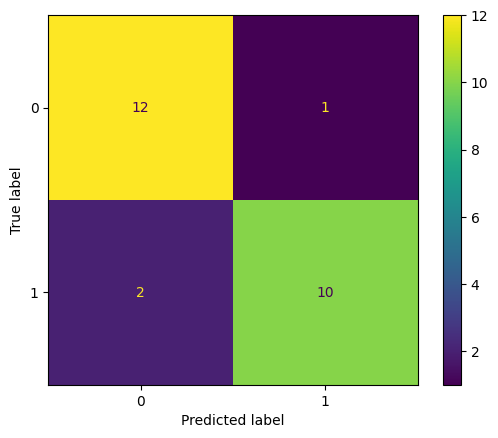

In [16]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [23]:
type(disp.figure_)

<class 'matplotlib.figure.Figure'>

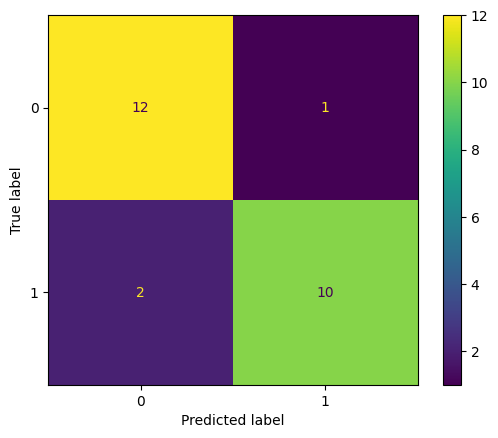

In [24]:
disp.figure_

In [1]:
catalog.load('tensorflow_model')

                    INFO     Loading data from 'tensorflow_model' (TensorFlowModelDataset)...   ]8;id=509727;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=650147;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.9/dist-packages/kedro/io/core.py:210 in load                              │
│                                                                                                  │
│   207 │   │   self._logger.debug("Loading %s", str(self))                                        │
│   208 │   │                                                                                      │
│   209 │   │   try:                                                                               │
│ ❱ 210 │   │   │   return self._load()                                                            │
│   211 │   │   except DatasetError:                                                               │
│   212 │   │   │   raise                                                                          │
│   213 │   │   except Exception as exc:                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/kedro/extras/datasets/tensorflow/tensorflow_model_dataset │
│ .py:141 in _load                                                                                 │
│                                                                                                  │
│   138 │   │   │   │   )  # noqa: redefined-loop-name                                             │
│   139 │   │   │   │   self._fs.copy(load_path, path)                                             │
│   140 │   │   │   else:                                                                          │
│ ❱ 141 │   │   │   │   self._fs.get(load_path, path, recursive=True)                              │
│   142 │   │   │                                                                                  │
│   143 │   │   │   # Pass the local temporary directory/file path to keras.load_model             │
│   144 │   │   │   device_name = self._load_args.pop("tf_device", None)                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/fsspec/spec.py:865 in get                                 │
│                                                                                                  │
│    862 │   │                                                                                     │
│    863 │   │   if isinstance(lpath, str):                                                        │
│    864 │   │   │   lpath = make_path_posix(lpath)                                                │
│ ❱  865 │   │   rpaths = self.expand_path(rpath, recursive=recursive)                             │
│    866 │   │   lpaths = other_paths(rpaths, lpath)                                               │
│    867 │   │                                                                                     │
│    868 │   │   callback.set_size(len(lpaths))                                                    │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/fsspec/spec.py:962 in expand_path                         │
│                                                                                                  │
│    959 │   │   """Turn one or more globs or directories into a list of all matching paths        │
│    960 │   │   to files or directories."""                                                       │
│    961 │   │   if isinstance(path, str):                                                         │
│ ❱  962 │   │   │   out = self.expand_path([path], recursive, maxdepth)                           │
│    963 │   │   else:                                                                             │
│    964 │   │   │   # reduce depth on each recursion level u

In [1]:
from entity_name_matching_dnn.pipelines.train_model.model import char2vecCNN

In [2]:
vocabulary = catalog.load('vocabulary_file')

[09/03/23 20:05:57] INFO     Loading data from 'vocabulary_file' (JSONDataSet)...               ]8;id=428156;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=552865;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

In [3]:
model = char2vecCNN(input_size=100,
        embedding_dim = 150,
        char_to_index = vocabulary)

2023-09-03 20:06:00.114627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import numpy as np

In [10]:
model.embedding_layer.predict(np.zeros(100)).shape

4/4 [==============================] - 0s 2ms/step


(100, 150)

In [1]:
train = catalog.load('train')

                    INFO     Loading data from 'train' (CSVDataSet)...                          ]8;id=508242;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=193738;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

In [3]:
train[train['name_normalized'].isnull()]

,reference_id,brand,name,alt_name,tags,latitude,longitude,category_fields,name_normalized,alt_name_normalized,run_id,country,target
124440,8180775532,NaN,!,Крутой спуск,"""license""=>""ODbL"", ""osm_uid""=>""1"", ""alt_name""=...",60.22126,29.755579,['tourism=information'],NaN,крутой спуск,20230901-test-0001,rus,1


In [6]:
catalog.load('df_normalized_pairs').groupBy('country').count().show()

[09/03/23 15:52:37] INFO     Loading data from 'df_normalized_pairs' (SparkDataSet)...          ]8;id=12891;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=241616;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

+-------+-----+
|country|count|
+-------+-----+
|    deu|45270|
|    bra| 9432|
|    fra| 9684|
|    rus| 8938|
|    esp| 6419|
|    ita| 6861|
|    nld| 1241|
|    ind| 1282|
|    mex| 1037|
+-------+-----+

